# IEOR 242 Assignment 09

In [34]:
import pandas as pd
import numpy as np
import pickle
import re

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import scale
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style="whitegrid")

In [35]:
import pymysql
from sqlalchemy import create_engine

# Connect to team database
engine = create_engine('mysql+pymysql://<user>:<password>@<host>[:<port>]/<dbname>')

In [36]:
# Path to the Pickle file
PICKLE_FILE = 'prepared_subsector.pickle'

# Path to the Loughran McDonald dictionary
MASTER_DICT_PATH = '../lecture/LoughranMcDonald_MasterDictionary_2014.xlsx'

# Random seed value for kmeans
KMEANS_SEED = 1234

## Data Loading

In [37]:
# Read the dataframe with file contents and labels from a Pickle file.
with open(PICKLE_FILE, 'rb') as f:
    class_df = pickle.load(f)

print('Number of reports: %d' % len(class_df))
class_df.head()

Number of reports: 3625


,content,cik,year,quarter,subsector,name,tic,saleq,saleq_change
0,Item7.Management's Discussion and Analysis of ...,855654.0,2012.0,3.0,35201010.0,IMMUNOGEN INC,IMGN,3.252,-9.225092251
1,The following discussion and analysis provide...,788920.0,2011.0,3.0,35101010.0,PRO-DEX INC/CO,PDEX,6.876,-1.89063409
2,Item 7. Managements Discussion and Analysis of...,795551.0,2011.0,1.0,35101010.0,THERAGENICS CORP,TGX,20.253,6.334863971
3,Managements Discussion and Analysis of Financ...,352915.0,2012.0,1.0,35102020.0,UNIVERSAL HEALTH SVCS INC,UHS,1755.536,-1.882217169
4,MANAGEMENTS DISCUSSION AND ANALYSIS OF FINANC...,884731.0,2013.0,1.0,35201010.0,ARIAD PHARMACEUTICALS INC,ARIA,6.464,116.769802


In [38]:
# Replace subsector codes with names
class_df.loc[class_df['subsector'] == 35101010.0, 'subsector'] = 'Health Care Equipment'
class_df.head()

,content,cik,year,quarter,subsector,name,tic,saleq,saleq_change
0,Item7.Management's Discussion and Analysis of ...,855654.0,2012.0,3.0,3.5201e+07,IMMUNOGEN INC,IMGN,3.252,-9.225092251
1,The following discussion and analysis provide...,788920.0,2011.0,3.0,Health Care Equipment,PRO-DEX INC/CO,PDEX,6.876,-1.89063409
2,Item 7. Managements Discussion and Analysis of...,795551.0,2011.0,1.0,Health Care Equipment,THERAGENICS CORP,TGX,20.253,6.334863971
3,Managements Discussion and Analysis of Financ...,352915.0,2012.0,1.0,3.5102e+07,UNIVERSAL HEALTH SVCS INC,UHS,1755.536,-1.882217169
4,MANAGEMENTS DISCUSSION AND ANALYSIS OF FINANC...,884731.0,2013.0,1.0,3.5201e+07,ARIAD PHARMACEUTICALS INC,ARIA,6.464,116.769802


## Feature Building

In [39]:
# Create regex to remove all non-characters from the report content
alpha_regex = re.compile('[^a-zA-Z]')

In [40]:
# Create vectorizer to calculate word count
cv = CountVectorizer(analyzer='word', stop_words='english', max_features=25000)
count_matrix = cv.fit_transform(class_df['content'].map(lambda c: alpha_regex.sub(' ', c)).tolist())

feature_names = cv.get_feature_names()
print('Number of features: %d' % len(feature_names))

Number of features: 25000


In [41]:
# Create a dataframe with word counts
count_df = pd.DataFrame(count_matrix.toarray())
count_df.columns = [i.upper() for i in feature_names]
print('Number of reports: %d' % len(count_df))
count_df.head()

Number of reports: 3625


,AA,AAA,AACHEN,AACR,AAHA,AAHP,AAN,AARP,AASCO,AASTROM,...,ZYMAXID,ZYME,ZYMENEX,ZYMOGENETICS,ZYNEX,ZYPREXA,ZYSTOR,ZYTIGA,ZZ,ZZI
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [42]:
# Remove outliers (reports that have word counts > 500)
count_df = count_df[count_df.apply(lambda x: x < 500).all(axis=1)]
print('Number of reports after outlier removal: %d' % len(count_df))
count_df.head()

Number of reports after outlier removal: 3600


,AA,AAA,AACHEN,AACR,AAHA,AAHP,AAN,AARP,AASCO,AASTROM,...,ZYMAXID,ZYME,ZYMENEX,ZYMOGENETICS,ZYNEX,ZYPREXA,ZYSTOR,ZYTIGA,ZZ,ZZI
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [43]:
# Merge report dataframe with word count
report_df = pd.merge(class_df, count_df, how='inner', left_index=True, right_index=True)
report_df.head()

,content,cik,year,quarter,subsector,name,tic,saleq,saleq_change,AA,...,ZYMAXID,ZYME,ZYMENEX,ZYMOGENETICS,ZYNEX,ZYPREXA,ZYSTOR,ZYTIGA,ZZ,ZZI
0,Item7.Management's Discussion and Analysis of ...,855654.0,2012.0,3.0,3.5201e+07,IMMUNOGEN INC,IMGN,3.252,-9.225092251,0,...,0,0,0,0,0,0,0,0,0,0
1,The following discussion and analysis provide...,788920.0,2011.0,3.0,Health Care Equipment,PRO-DEX INC/CO,PDEX,6.876,-1.89063409,0,...,0,0,0,0,0,0,0,0,0,0
2,Item 7. Managements Discussion and Analysis of...,795551.0,2011.0,1.0,Health Care Equipment,THERAGENICS CORP,TGX,20.253,6.334863971,0,...,0,0,0,0,0,0,0,0,0,0
3,Managements Discussion and Analysis of Financ...,352915.0,2012.0,1.0,3.5102e+07,UNIVERSAL HEALTH SVCS INC,UHS,1755.536,-1.882217169,0,...,0,0,0,0,0,0,0,0,0,0
4,MANAGEMENTS DISCUSSION AND ANALYSIS OF FINANC...,884731.0,2013.0,1.0,3.5201e+07,ARIAD PHARMACEUTICALS INC,ARIA,6.464,116.769802,0,...,0,0,0,0,0,0,0,0,0,0


In [44]:
# Check how many reports are in each subsector
report_df['subsector'].value_counts()

35201010.0               1189
Health Care Equipment     684
35202010.0                519
35102015.0                305
35101020.0                225
35203010.0                220
35103010.0                164
35102020.0                152
35102010.0                 74
35102030.0                 68
Name: subsector, dtype: int64

In [47]:
# Number of unique companies
len(np.unique(report_df['cik']))

1006

## Scoring with Finance Dictionary
Loughran-McDonalds dictionary source: http://www3.nd.edu/~mcdonald/Word_Lists.html

In [10]:
# Loading the dictionary
dict = pd.read_excel(MASTER_DICT_PATH)
dict.head()

,Word,Sequence Number,Word Count,Word Proportion,Average Proportion,Std Dev,Doc Count,Negative,Positive,Uncertainty,Litigious,Constraining,Superfluous,Interesting,Modal,Irr_Verb,Harvard_IV,Syllables,Source
0,AARDVARK,1,81,5.690194e-09,3.068740e-09,5.779943e-07,45,0,0,0,0,0,0,0,0,0,0,2,12of12inf
1,AARDVARKS,2,2,1.404986e-10,8.217606e-12,7.841870e-09,1,0,0,0,0,0,0,0,0,0,0,2,12of12inf
2,ABACI,3,8,5.619945e-10,1.686149e-10,7.096240e-08,7,0,0,0,0,0,0,0,0,0,0,3,12of12inf
3,ABACK,4,5,3.512466e-10,1.727985e-10,7.532677e-08,5,0,0,0,0,0,0,0,0,0,0,2,12of12inf
4,ABACUS,5,1752,1.230768e-07,1.198634e-07,1.110293e-05,465,0,0,0,0,0,0,0,0,0,0,3,12of12inf


In [11]:
# Create a smaller dictionary that only contains the words which are used in the reports
minidict = dict[dict['Word'].isin(report_df.columns)]
minidict = minidict.set_index('Word')

# Clean the positive & negative columns
minidict.loc[minidict['Positive'] > 0, 'Positive'] = 1
minidict.loc[minidict['Negative'] > 0, 'Negative'] = -1
minidict.head()

,Sequence Number,Word Count,Word Proportion,Average Proportion,Std Dev,Doc Count,Negative,Positive,Uncertainty,Litigious,Constraining,Superfluous,Interesting,Modal,Irr_Verb,Harvard_IV,Syllables,Source
Word,,,,,,,,,,,,,,,,,,
ABANDON,10,80492,5.654508e-06,5.249083e-06,0.000041,45941,-1,0,0,0,0,0,0,0,0,1,3,12of12inf
ABANDONED,11,174298,1.224431e-05,1.221126e-05,0.000088,83234,-1,0,0,0,0,0,0,0,0,2,3,12of12inf
ABANDONING,12,15926,1.118791e-06,9.946277e-07,0.000015,10125,-1,0,0,0,0,0,0,0,0,2,4,12of12inf
ABANDONMENT,13,177889,1.249658e-05,1.187335e-05,0.000082,65686,-1,0,0,0,0,0,0,0,0,1,4,12of12inf
ABANDONMENTS,14,7091,4.981379e-07,6.848194e-07,0.000017,3891,-1,0,0,0,0,0,0,0,0,2,4,12of12inf


In [12]:
# Just some transformations to facilitate merging
count_merge_df = count_df.T 
count_merge_df.index.name = 'Word'
count_merge_df.head()

,0,1,2,3,4,5,6,8,9,10,...,3615,3616,3617,3618,3619,3620,3621,3622,3623,3624
Word,,,,,,,,,,,,,,,,,,,,,
AA,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AAA,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
AACHEN,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AACR,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AAHA,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [13]:
# Merge the dictionary with the report dataframe
senti_df = pd.merge(count_merge_df, minidict, how='inner', left_index=True, right_index=True)
senti_df.head()

,0,1,2,3,4,5,6,8,9,10,...,Uncertainty,Litigious,Constraining,Superfluous,Interesting,Modal,Irr_Verb,Harvard_IV,Syllables,Source
Word,,,,,,,,,,,,,,,,,,,,,
ABANDON,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,3,12of12inf
ABANDONED,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,2,3,12of12inf
ABANDONING,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,2,4,12of12inf
ABANDONMENT,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,4,12of12inf
ABANDONMENTS,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,2,4,12of12inf


In [14]:
# Calculate sentiments for each report and add it to the classification and report dataframe
for i, row in report_df.iterrows():
    class_df.loc[i, 'sentiment'] = sum(senti_df[i] * senti_df['Positive'] + senti_df[i] * senti_df['Negative'])
    report_df.loc[i, 'sentiment'] = sum(senti_df[i] * senti_df['Positive'] + senti_df[i] * senti_df['Negative'])
report_df.head()

,content,cik,year,quarter,subsector,name,tic,saleq,saleq_change,AA,...,ZYME,ZYMENEX,ZYMOGENETICS,ZYNEX,ZYPREXA,ZYSTOR,ZYTIGA,ZZ,ZZI,sentiment
0,Item7.Management's Discussion and Analysis of ...,855654.0,2012.0,3.0,35201010.0,IMMUNOGEN INC,IMGN,3.252,-9.225092251,0,...,0,0,0,0,0,0,0,0,0,121.0
1,The following discussion and analysis provide...,788920.0,2011.0,3.0,35101010.0,PRO-DEX INC/CO,PDEX,6.876,-1.89063409,0,...,0,0,0,0,0,0,0,0,0,-9.0
2,Item 7. Managements Discussion and Analysis of...,795551.0,2011.0,1.0,35101010.0,THERAGENICS CORP,TGX,20.253,6.334863971,0,...,0,0,0,0,0,0,0,0,0,-180.0
3,Managements Discussion and Analysis of Financ...,352915.0,2012.0,1.0,35102020.0,UNIVERSAL HEALTH SVCS INC,UHS,1755.536,-1.882217169,0,...,0,0,0,0,0,0,0,0,0,-179.0
4,MANAGEMENTS DISCUSSION AND ANALYSIS OF FINANC...,884731.0,2013.0,1.0,35201010.0,ARIAD PHARMACEUTICALS INC,ARIA,6.464,116.769802,0,...,0,0,0,0,0,0,0,0,0,-25.0


## PCA
http://scikit-learn.org/stable/modules/decomposition.html#pca

In [15]:
# Perform two-dimensional PCA on the scaled token count
pca = PCA(n_components=2)
pca_result = pd.DataFrame(pca.fit_transform(scale(count_df)))
pca_result.columns = ['pca1', 'pca2']
pca_result.head()

,pca1,pca2
0,1.457141,-8.083183
1,-14.773185,0.034567
2,23.202247,12.456592
3,48.503857,38.294771
4,3.778692,-8.320153


In [16]:
# Extract components
pca_components = pd.merge(pd.DataFrame(feature_names), pd.DataFrame(pca.components_.T),
                          how='inner', left_index=True, right_index=True)
pca_components.columns = ['token', 'pca1', 'pca2']
pca_components.head()

,token,pca1,pca2
0,aa,0.011517,0.012027
1,aaa,0.003747,0.003483
2,aachen,-0.000291,0.000098
3,aacr,0.003506,-0.007452
4,aaha,-0.000224,0.000256


In [17]:
# Highest PCA 1 components
pca_components.sort_values('pca1', ascending=False)[['token', 'pca1']].head()

,token,pca1
10956,including,0.041821
21500,subject,0.039143
390,addition,0.038497
10953,include,0.038340
9171,future,0.038319


In [18]:
# Lowest PCA 1 components
pca_components.sort_values('pca1', ascending=True)[['token', 'pca1']].head()

,token,pca1
3149,burn,-0.002456
9522,glucosamine,-0.002174
2783,bodes,-0.002121
10863,implies,-0.002117
22177,tel,-0.002111


In [19]:
# Highest PCA 2 components
pca_components.sort_values('pca2', ascending=False)[['token', 'pca2']].head()

,token,pca2
18331,rate,0.034377
18335,rates,0.033455
8788,flows,0.032260
10960,income,0.031543
5415,credit,0.031289


In [20]:
# Lowest PCA 2 components
pca_components.sort_values('pca2', ascending=True)[['token', 'pca2']].head()

,token,pca2
1394,applicant,-0.048981
3313,candidates,-0.047827
22946,trials,-0.047048
14723,ndas,-0.047029
6352,devise,-0.046676


## K-Means
http://scikit-learn.org/stable/modules/clustering.html#k-means

In [21]:
# Perform k-means with k=10 (because there are 10 sub-sectors)
kmeans = KMeans(n_clusters=10, random_state=KMEANS_SEED, n_jobs=4)
kmeans_result = pd.DataFrame(kmeans.fit_predict(count_df))
kmeans_result.columns = ['cluster']
kmeans_result.head()

,cluster
0,6
1,5
2,3
3,8
4,6


In [22]:
# Check how many reports are in each cluster
kmeans_result['cluster'].value_counts()

5    1210
0     680
3     582
7     470
6     265
8     118
4      87
9      81
1      80
2      27
Name: cluster, dtype: int64

## Merge Results

In [23]:
# Merge report dataframe with PCA components and k-means cluster
print('Number of reports: %d' % len(class_df))
report_pca = pd.merge(class_df.drop('content', axis=1), pca_result, how='inner', left_index=True, right_index=True)
print('Number of reports with PCA: %d' % len(report_pca))
report_pca_kmeans = pd.merge(report_pca, kmeans_result, how='inner', left_index=True, right_index=True)
print('Number of reports with PCA and k-means: %d' % len(report_pca_kmeans))
report_pca_kmeans.head()

Number of reports: 3625
Number of reports with PCA: 3600
Number of reports with PCA and k-means: 3600


,cik,year,quarter,subsector,name,tic,saleq,saleq_change,sentiment,pca1,pca2,cluster
0,855654.0,2012.0,3.0,35201010.0,IMMUNOGEN INC,IMGN,3.252,-9.225092251,121.0,1.457141,-8.083183,6
1,788920.0,2011.0,3.0,35101010.0,PRO-DEX INC/CO,PDEX,6.876,-1.89063409,-9.0,-14.773185,0.034567,5
2,795551.0,2011.0,1.0,35101010.0,THERAGENICS CORP,TGX,20.253,6.334863971,-180.0,23.202247,12.456592,3
3,352915.0,2012.0,1.0,35102020.0,UNIVERSAL HEALTH SVCS INC,UHS,1755.536,-1.882217169,-179.0,48.503857,38.294771,8
4,884731.0,2013.0,1.0,35201010.0,ARIAD PHARMACEUTICALS INC,ARIA,6.464,116.769802,-25.0,3.778692,-8.320153,6


In [24]:
# Write data to database
report_pca_kmeans.to_sql('report_pca_kmeans', engine, if_exists='replace')

In [27]:
# Load data from the database
report_pca_kmeans = pd.read_sql_query('SELECT * FROM report_pca_kmeans', engine)

## Visualization 1
Check distribution of PCA clusters.

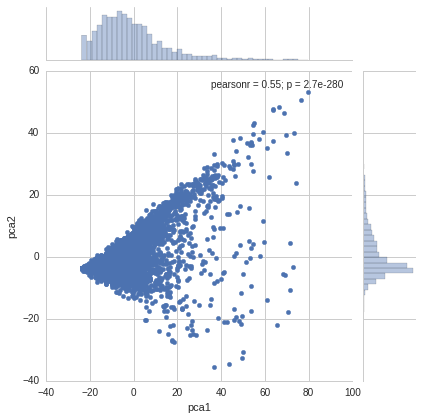

In [43]:
vis_df = report_pca_kmeans.loc[(report_pca_kmeans['pca1'] < 80) & (report_pca_kmeans['pca2'] > -40)]
sns.jointplot(x='pca1', y='pca2', data=vis_df)

## Visualization 2
2-dimensional plot of PCA for 2014 10-K reports, bubble size is log(sales turnover) and bubbles are colored by subsector.

In [32]:
# Prepare data
json_export_df = report_pca_kmeans.loc[(report_pca_kmeans['year'] == 2014) &
                                       (report_pca_kmeans['pca1'] < 80) &
                                       (report_pca_kmeans['pca2'] > -40),
                                       ['tic', 'subsector', 'pca1', 'pca2', 'saleq']]
json_export_df.columns = ['Company Name', 'Cluster', 'coordinate_x', 'coordinate_y', 'r']
json_export_df['Cluster'] = json_export_df['Cluster'].astype(str)
json_export_df['r'] = np.log(json_export_df['r'])
json_export_df = json_export_df.replace(-np.inf, np.nan)
json_export_df.describe()

,coordinate_x,coordinate_y,r
count,734.000000,734.000000,579.000000
mean,-1.055501,0.320324,2.326907
std,15.814753,9.107724,3.399512
min,-23.893210,-35.506064,-6.907755
25%,-12.402117,-4.500085,0.151832
50%,-4.044218,-2.376518,2.209921
75%,4.875714,3.521820,4.777802
max,70.301528,47.180416,10.709025


In [ ]:
# Export data to JSON for d3.js visualization
json_export_df.to_json(None, orient='records')

## Visualization 3
2-dimensional plot of PCA for 2014 10-K reports, bubble size is log(sales turnover) and bubbles are colored by k-means clustering.

In [34]:
# Prepare data
json_export_df = report_pca_kmeans.loc[(report_pca_kmeans['year'] == 2014) &
                                       (report_pca_kmeans['pca1'] < 80) &
                                       (report_pca_kmeans['pca2'] > -40),
                                       ['tic', 'cluster', 'pca1', 'pca2', 'saleq']]
json_export_df.columns = ['Company Name', 'Cluster', 'coordinate_x', 'coordinate_y', 'r']
json_export_df['Cluster'] = json_export_df['Cluster'].astype(str)
json_export_df['r'] = np.log(json_export_df['r'])
json_export_df = json_export_df.replace(-np.inf, np.nan)
json_export_df.describe()

,coordinate_x,coordinate_y,r
count,734.000000,734.000000,579.000000
mean,-1.055501,0.320324,2.326907
std,15.814753,9.107724,3.399512
min,-23.893210,-35.506064,-6.907755
25%,-12.402117,-4.500085,0.151832
50%,-4.044218,-2.376518,2.209921
75%,4.875714,3.521820,4.777802
max,70.301528,47.180416,10.709025


In [ ]:
# Export data to JSON for d3.js visualization
json_export_df.to_json(None, orient='records')

## Visualization 4
2-dimensional plot of PCA for 2014 10-K reports, bubble size is log(sales turnover) and bubbles are colored by positive/negative reports.

In [39]:
# Prepare data
json_export_df = report_pca_kmeans.loc[(report_pca_kmeans['year'] == 2014) &
                                       (report_pca_kmeans['pca1'] < 80) &
                                       (report_pca_kmeans['pca2'] > -40),
                                       ['tic', 'sentiment', 'pca1', 'pca2', 'saleq']]
json_export_df.columns = ['Company Name', 'Cluster', 'coordinate_x', 'coordinate_y', 'r']
json_export_df['Cluster'] = json_export_df['Cluster'].apply(lambda r: 'Pos' if (r >= 0) else 'Neg')
json_export_df['r'] = np.log(json_export_df['r'])
json_export_df = json_export_df.replace(-np.inf, np.nan)
json_export_df.describe()

,coordinate_x,coordinate_y,r
count,734.000000,734.000000,579.000000
mean,-1.055501,0.320324,2.326907
std,15.814753,9.107724,3.399512
min,-23.893210,-35.506064,-6.907755
25%,-12.402117,-4.500085,0.151832
50%,-4.044218,-2.376518,2.209921
75%,4.875714,3.521820,4.777802
max,70.301528,47.180416,10.709025


In [ ]:
# Export data to JSON for d3.js visualization
json_export_df.to_json(None, orient='records')

## Visualization 5
Line chart for the sentiment development of each subsector over the year.

In [76]:
vis_df = pd.merge(report_pca_kmeans[['year']], report_pca_kmeans.pivot(columns='subsector', values='sentiment'),
                  how='inner', left_index=True, right_index=True).groupby('year').mean()
vis_df

,35101010.0,35101020.0,35102010.0,35102015.0,35102020.0,35102030.0,35103010.0,35201010.0,35202010.0,35203010.0
year,,,,,,,,,,
2009.0,-65.000000,-58.500000,-12.000000,-38.000000,-71.000000,NaN,-24.000000,-28.857143,-22.083333,-8.500000
2010.0,-54.614286,-34.627907,-61.437500,-57.324324,-106.742857,-136.875000,-35.468750,-23.070796,-41.967742,-45.063830
2011.0,-50.704545,-39.125000,-46.461538,-55.691176,-115.406250,-120.142857,-37.903226,-16.971831,-46.285714,-42.065217
2012.0,-47.476923,-32.772727,-70.000000,-71.240741,-116.620690,-101.071429,-37.727273,-18.572072,-37.873786,-39.023256
2013.0,-44.757576,-31.902439,-75.846154,-73.754717,-102.758621,-85.833333,-30.758621,-19.279661,-38.704082,-47.825000
2014.0,-42.901515,-30.833333,-61.615385,-54.870370,-103.818182,-60.750000,-41.000000,-15.075812,-43.854545,-40.390244


## Visualization 6

In [78]:
report_pca_kmeans.head()

,index,cik,year,quarter,subsector,name,tic,saleq,saleq_change,sentiment,pca1,pca2,cluster
0,0,855654.0,2012.0,3.0,35201010.0,IMMUNOGEN INC,IMGN,3.252,-9.225092251,121.0,1.457141,-8.083183,6
1,1,788920.0,2011.0,3.0,35101010.0,PRO-DEX INC/CO,PDEX,6.876,-1.89063409,-9.0,-14.773185,0.034567,5
2,2,795551.0,2011.0,1.0,35101010.0,THERAGENICS CORP,TGX,20.253,6.334863971,-180.0,23.202247,12.456592,3
3,3,352915.0,2012.0,1.0,35102020.0,UNIVERSAL HEALTH SVCS INC,UHS,1755.536,-1.882217169,-179.0,48.503857,38.294771,8
4,4,884731.0,2013.0,1.0,35201010.0,ARIAD PHARMACEUTICALS INC,ARIA,6.464,116.769802,-25.0,3.778692,-8.320153,6


## Visualization 6
2-dimensional plot of PCA for **35201010** (Biotechnology) 10-K reports, bubble size is log(sales turnover) and bubbles are colored by positive/negative reports.

In [28]:
# Prepare data
json_export_df = report_pca_kmeans.loc[(report_pca_kmeans['subsector'] == 35201010.0) &
                                       (report_pca_kmeans['pca1'] < 80) &
                                       (report_pca_kmeans['pca2'] > -40),
                                       ['tic', 'sentiment', 'pca1', 'pca2', 'saleq']]
json_export_df.columns = ['Company Name', 'Cluster', 'coordinate_x', 'coordinate_y', 'r']
json_export_df['Cluster'] = json_export_df['Cluster'].apply(lambda r: 'Pos' if (r >= 0) else 'Neg')
json_export_df['r'] = np.log(json_export_df['r'])
json_export_df = json_export_df.replace(-np.inf, np.nan)
json_export_df.describe()

,coordinate_x,coordinate_y,r
count,1173.000000,1173.000000,759.000000
mean,-1.309439,0.320483,0.709545
std,15.285911,8.300257,2.864925
min,-23.893210,-32.736559,-6.907755
25%,-12.267826,-4.379033,-1.267662
50%,-3.863051,-2.198875,0.793445
75%,5.495815,4.051210,2.509226
max,74.428761,38.034347,8.516984


In [ ]:
# Export data to JSON for d3.js visualization
json_export_df.to_json(None, orient='records')

## Visualization 7
2-dimensional plot of PCA for **35101010** (Health Care Equipment) 10-K reports, bubble size is log(sales turnover) and bubbles are colored by positive/negative reports.

In [30]:
# Prepare data
json_export_df = report_pca_kmeans.loc[(report_pca_kmeans['subsector'] == 35101010.0) &
                                       (report_pca_kmeans['pca1'] < 80) &
                                       (report_pca_kmeans['pca2'] > -40),
                                       ['tic', 'sentiment', 'pca1', 'pca2', 'saleq']]
json_export_df.columns = ['Company Name', 'Cluster', 'coordinate_x', 'coordinate_y', 'r']
json_export_df['Cluster'] = json_export_df['Cluster'].apply(lambda r: 'Pos' if (r >= 0) else 'Neg')
json_export_df['r'] = np.log(json_export_df['r'])
json_export_df = json_export_df.replace(-np.inf, np.nan)
json_export_df.describe()

,coordinate_x,coordinate_y,r
count,672.000000,672.000000,599.000000
mean,-0.229968,1.147539,2.625469
std,15.960465,9.313135,2.925225
min,-23.893210,-25.083630,-6.907755
25%,-11.534648,-4.414001,0.757989
50%,-3.888201,-2.089672,2.722085
75%,7.237390,5.357527,4.691453
max,70.665439,48.214949,9.109508


In [ ]:
# Export data to JSON for d3.js visualization
json_export_df.to_json(None, orient='records')

## Subsector Prediction
Predicting the subsector of a company based on the bag-of-words features using a SVM, limited to 2014 reports.

In [102]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.cross_validation import train_test_split

In [103]:
# Create train and test set based on 2014 reports
X = count_df.loc[report_df['year'] == 2014, :]
y = report_df.loc[report_df['year'] == 2014, 'subsector']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=KMEANS_SEED)

In [104]:
# Train the SVM
classifier = SVC()
classifier.fit(X_train, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [105]:
# Build a classification report using the test set
y_pred = classifier.predict(X_test)
print('Accuracy: %f' % accuracy_score(y_test, y_pred))

Accuracy: 0.446721


In [106]:
# Print the classification report
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

 35101010.0       0.20      0.33      0.25        33
 35101020.0       0.00      0.00      0.00        19
 35102010.0       0.00      0.00      0.00         6
 35102015.0       0.67      0.12      0.21        16
 35102020.0       0.00      0.00      0.00         9
 35102030.0       0.00      0.00      0.00         5
 35103010.0       0.00      0.00      0.00         9
 35201010.0       0.52      0.94      0.67       102
 35202010.0       0.00      0.00      0.00        29
 35203010.0       0.00      0.00      0.00        16

avg / total       0.29      0.45      0.33       244



/home/stefan/anaconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [107]:
# Print the confusion matrix
print(confusion_matrix(y_test, y_pred))

[[11  0  0  0  0  0  0 22  0  0]
 [17  0  0  0  0  0  0  2  0  0]
 [ 3  0  0  0  0  0  0  3  0  0]
 [ 4  0  0  2  0  0  0 10  0  0]
 [ 1  0  0  0  0  0  0  8  0  0]
 [ 0  0  0  1  0  0  0  4  0  0]
 [ 3  0  0  0  0  0  0  6  0  0]
 [ 5  0  0  0  0  0  0 96  1  0]
 [ 6  0  0  0  0  0  0 23  0  0]
 [ 5  0  0  0  0  0  0 11  0  0]]
